Problem Statement:

Scientists have determined that a known species of bird should be divided into 3 distinct and separate species. These species are endemic to a particular region of the country and their populations must be tracked and estimated with as much precision as possible. As such, a non-profit conservation society has taken up the task. They need to be able to log which species they have encountered based on the characteristics that their field officers observe in the wild. 

Using certain genetic traits and location data, can you predict the species of bird that has been observed?

This is a beginner-level practice competition and your goal is to predict the bird species (A, B, or C) based on attributes or location.

## Import libraries

In [46]:
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


First we import the necessary libraries we need.

## Helper functions

In [2]:
def missing_vals(df):
    """prints out columns with perc of missing values"""
    missing = [
        (df.columns[idx], perc)
        for idx, perc in enumerate(df.isna().mean() * 100)
        if perc > 0
    ]

    if len(missing) == 0:
        return "no missing values"
        

    # sort desc by perc
    missing.sort(key=lambda x: x[1], reverse=True)

    print(f"There are a total of {len(missing)} variables with missing values\n")

    for tup in missing:
        print(str.ljust(f"{tup[0]:<20} => {round(tup[1], 3)}%", 1))

Above is a helper function to show missing values.

## Load data

In [3]:
train = pd.read_csv("dataset/training_set/training_set.csv")
labels = pd.read_csv("dataset/training_set/training_target.csv")

# join target variable to training set
train = train.merge(labels, on="ID")

test = pd.read_csv("dataset/test_set/test_set.csv")

First we load the train and test data using the `read_csv` function.

We also merge `training_set.csv` (containing the features) with `training_target.csv` (containing the target variable) and form the train data.

In [4]:
train.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.300000,48.200000,210.000000,loc_2,4600.0,0.0,284,C
1,14.400000,48.400000,203.000000,loc_2,4625.0,0.0,101,C
2,18.400000,NaN,200.000000,loc_3,3400.0,0.0,400,B
3,14.982114,47.504878,NaN,NaN,4800.0,0.0,98,C
4,18.982114,38.259307,217.186992,loc_3,5200.0,0.0,103,C


Using the head function we can peek into the first 5 rows of the data

In [5]:
target_cols = "species"
num_cols = ["bill_depth", "bill_length", "wing_length", "mass"]
cat_cols = ["location", "sex"]
all_cols = num_cols + cat_cols + [target_cols]

train = train[all_cols]

## Exploratory Data Analysis (EDA)

This is where we look into the trends and patterns of the data, both numerical and categorical.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 0 to 434
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_depth   434 non-null    float64
 1   bill_length  295 non-null    float64
 2   wing_length  298 non-null    float64
 3   mass         433 non-null    float64
 4   location     405 non-null    object 
 5   sex          379 non-null    float64
 6   species      435 non-null    object 
dtypes: float64(5), object(2)
memory usage: 27.2+ KB


With the `info` function we can see the number of rows and data type.

### Numerical

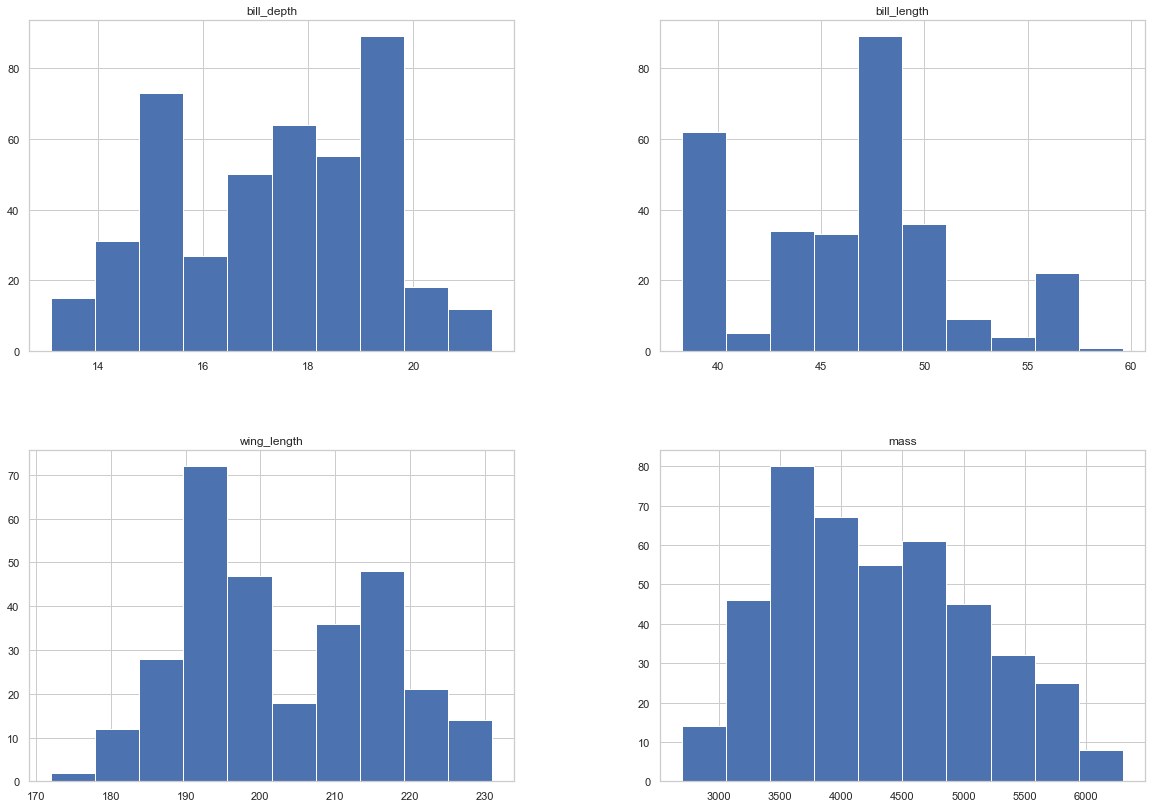

In [7]:
train[num_cols].hist(figsize=(20, 14));

Let's plot the histograms of the numerical variables.

- bill_depth peaks around 15 and 19
- bill length peaks around 39 and 47
- wing length peaks around 190 and 216
- mass is right skewed

### Categorical

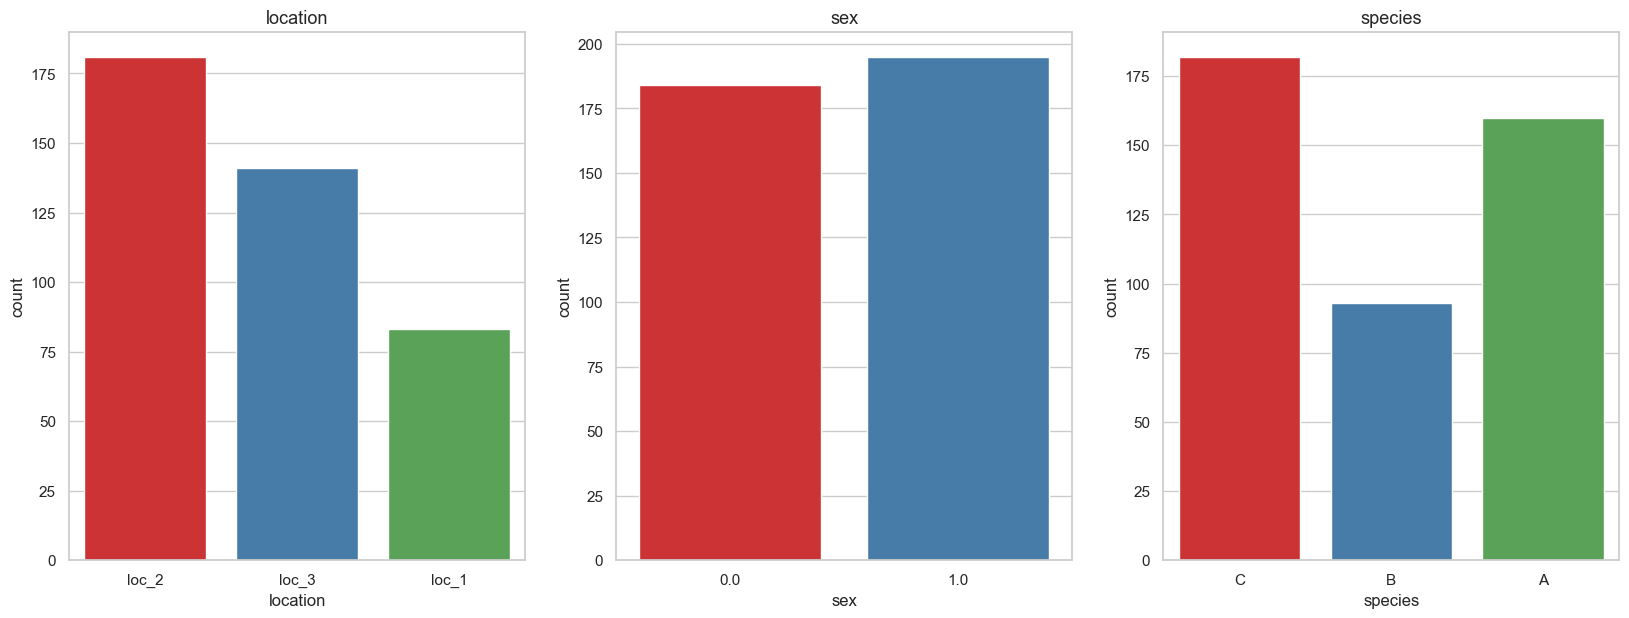

In [8]:
to_plot = cat_cols + [target_cols]
fig, axes = plt.subplots(1, 3, figsize=(20, 7), dpi=100)

for i, col_name in enumerate(train[to_plot].columns):
    sns.countplot(x = col_name, data = train, palette="Set1", ax=axes[i % 3])
    axes[i % 3].set_title(f"{col_name}", fontsize=13)
    plt.subplots_adjust(hspace=0.45)

We see location and species seemingly matches for their respective locations and species (loc2 & species C, loc3 & species A). We also see there are slightly more female (1) birds than the male counterpart.

In [9]:
train.species.value_counts()

C    182
A    160
B     93
Name: species, dtype: int64

With a closer look, we see the target variable is imbalanced, where class B is almost 100 class lower than C, and around 70 lower than A.

Imbalanced class is an issue because it biases the model to place more importance on classes with more samples ie. C is predicted a lot more often than B.

## Missing Data

### Percentages of missing values

In [10]:
missing_vals(train)

There are a total of 6 variables with missing values

bill_length          => 32.184%
wing_length          => 31.494%
sex                  => 12.874%
location             => 6.897%
mass                 => 0.46%
bill_depth           => 0.23%


With our helper function, we find out that bill_length and wing_length has over 30% of missing values

### Heatplot

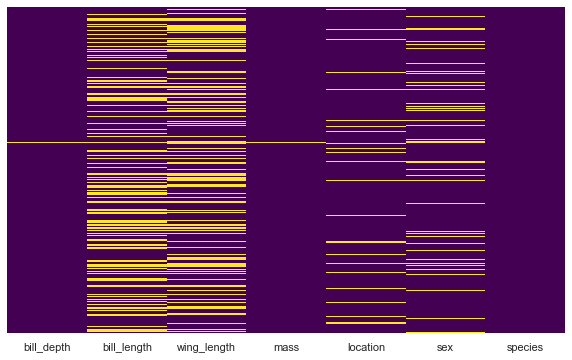

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis', cbar=False);

We can also plot a heatmap to visualize the missing values and see if there are any patterns

### Impute categorical columns

let's first see how many missing variables are in our categorical variables

In [12]:
train.sex.value_counts(dropna=False)

1.0    195
0.0    184
NaN     56
Name: sex, dtype: int64

In [13]:
train.location.value_counts(dropna=False)

loc_2    181
loc_3    141
loc_1     83
NaN       30
Name: location, dtype: int64

Let's use the simple imputer to deal with them by replacing them with the most frequent value.

In [14]:
cat_imp = SimpleImputer(strategy="most_frequent")

train[cat_cols] = cat_imp.fit_transform(train[cat_cols])

In [15]:
train.sex.value_counts(dropna=False)

1.0    251
0.0    184
Name: sex, dtype: int64

As you can see, by the 'most_frequent' strategy, the missing values were imputed with 1.0, which was the most frequent.

### Impute numerical columns

Let's use the median value to impute our numerical values

In [16]:
num_imp = SimpleImputer(strategy="median")

train[num_cols] = num_imp.fit_transform(train[num_cols])

In [17]:
missing_vals(train)

'no missing values'

## Feature Engineering

In [18]:
train.species.value_counts()

C    182
A    160
B     93
Name: species, dtype: int64

### encode categorical variables

With the label encoder, we can encode our categorical variables (and target variable) into numerical values. WE do this becaues most ML models don't work with string values

In [19]:
le = LabelEncoder()
le.fit(train['species'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'A': 0, 'B': 1, 'C': 2}

We can fit the encoder on the variable first, and view what the mappping is like, so we can invert the mapping later

In [20]:
train['species'] = le.fit_transform(train['species'])

For other columns with string variables (non-numeric), we also do the same encoding

In [21]:
for col in cat_cols:
    if train[col].dtype == "object":
        train[col] = le.fit_transform(train[col])

In [22]:
train.head()

,bill_depth,bill_length,wing_length,mass,location,sex,species
0,14.300000,48.200000,210.000000,4600.0,1,0,2
1,14.400000,48.400000,203.000000,4625.0,1,0,2
2,18.400000,47.500000,200.000000,3400.0,2,0,1
3,14.982114,47.504878,199.000000,4800.0,1,0,2
4,18.982114,38.259307,217.186992,5200.0,2,0,2


In [23]:
# Convert cat_features to pd.Categorical dtype
for col in cat_cols:
    train[col] = pd.Categorical(train[col])

We also convert categorical features into the pd.Categorical dtype

In [24]:
train.dtypes

bill_depth      float64
bill_length     float64
wing_length     float64
mass            float64
location       category
sex            category
species           int64
dtype: object

## Creating new features

In [25]:
train['b_depth_length_ratio'] = train['bill_depth'] / train['bill_length']
train['b_length_depth_ratio'] = train['bill_length'] / train['bill_depth']
train['w_length_mass_ratio'] = train['wing_length'] / train['mass']

Here we create some features with division to form ratios of variables 

In [26]:
train.head()

,bill_depth,bill_length,wing_length,mass,location,sex,species,b_depth_length_ratio,b_length_depth_ratio,w_length_mass_ratio
0,14.300000,48.200000,210.000000,4600.0,1,0,2,0.296680,3.370629,0.045652
1,14.400000,48.400000,203.000000,4625.0,1,0,2,0.297521,3.361111,0.043892
2,18.400000,47.500000,200.000000,3400.0,2,0,1,0.387368,2.581522,0.058824
3,14.982114,47.504878,199.000000,4800.0,1,0,2,0.315381,3.170773,0.041458
4,18.982114,38.259307,217.186992,5200.0,2,0,2,0.496144,2.015545,0.041767


## Modeling

### Train test split

Now it's time to build the model, we first split it into X (features) and y (target variable), and then split it into training and evaluation set. 

Training is where we train the model, evaluation is where we test the model before fitting it to the test set.

In [27]:
X, y = train.drop(["species"], axis=1), train[["species"]].values.flatten()

In [28]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.25, random_state=0)

## Fit a simple Decision Tree Classifier

Here we fit a baseline model with a simple hyperparameter of max_depth = 2

In [29]:
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)

After we fit the data, we can use it to make predictions

In [30]:
dtree_pred = dtree_model.predict(X_eval)

## Model Performance

In [31]:
print(classification_report(dtree_pred, y_eval))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        57
           1       0.71      0.92      0.80        13
           2       0.75      1.00      0.86        39

    accuracy                           0.83       109
   macro avg       0.82      0.87      0.83       109
weighted avg       0.88      0.83      0.83       109



The classification report shows us useful metrics for our classifier. 

For example, the f1-score of our model is 0.83

## Confusion matrix

We can also build a confusion matrix to visualize what our classifier is doing well/bad at.

Confusion matrix, without normalization
[[40  0  0]
 [ 5 12  0]
 [12  1 39]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.29411765 0.70588235 0.        ]
 [0.23076923 0.01923077 0.75      ]]


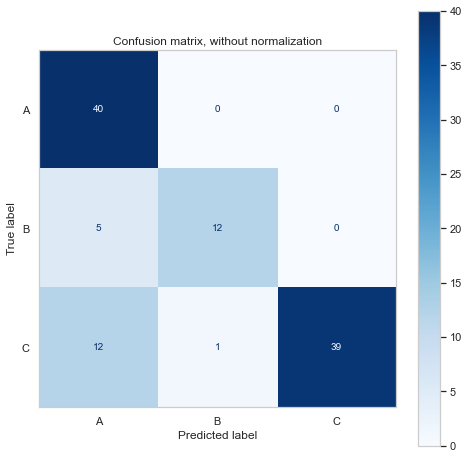

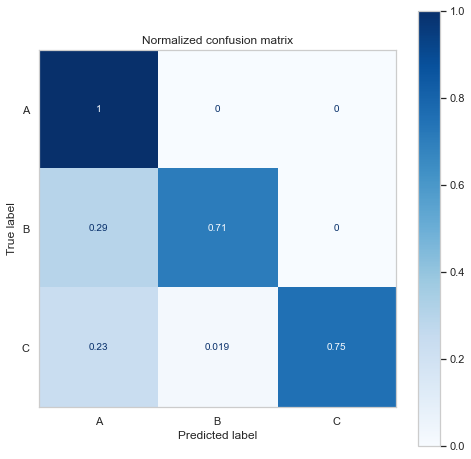

In [33]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        dtree_model,
        X_eval,
        y_eval,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

The confusion matrix shows us that it is predicting more classes A and C, which is not surprising since we had more samples.

It also shows the model is predicting more A classes when it should be B/C.

## Feature importance

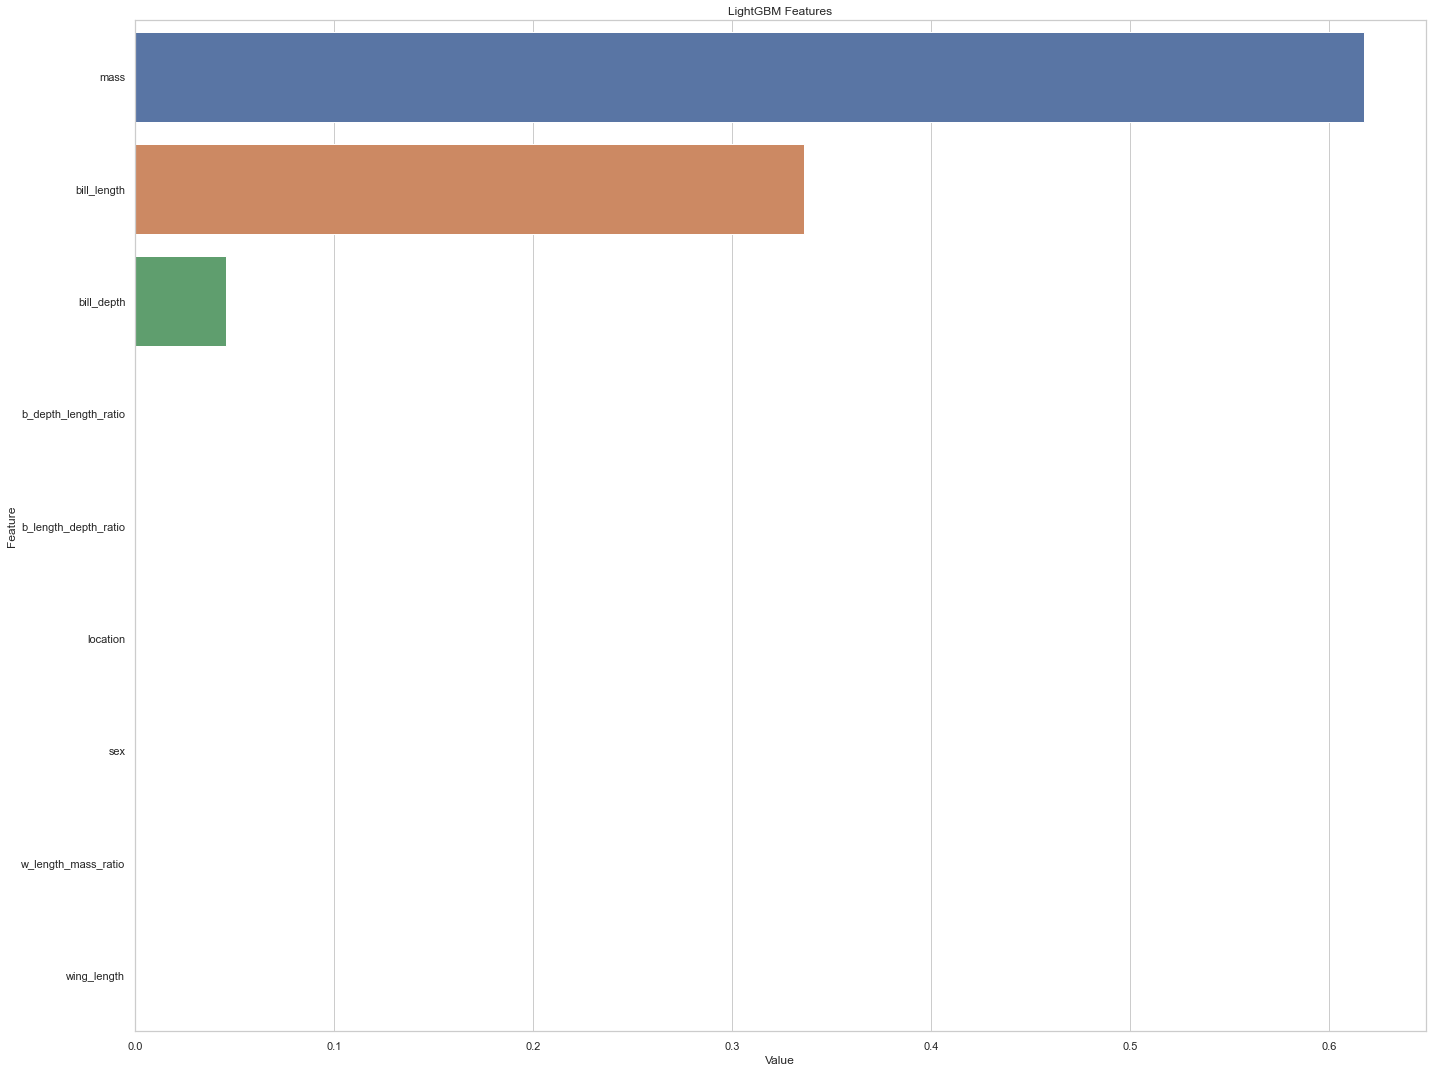

In [34]:
feature_imp = pd.DataFrame(sorted(zip(dtree_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
# plt.savefig('lightgbm_fimp.png')

From the feature importance, it seems mass is the best at predicting species, second is bill length. Other variables seem to have zero importance in the classifier

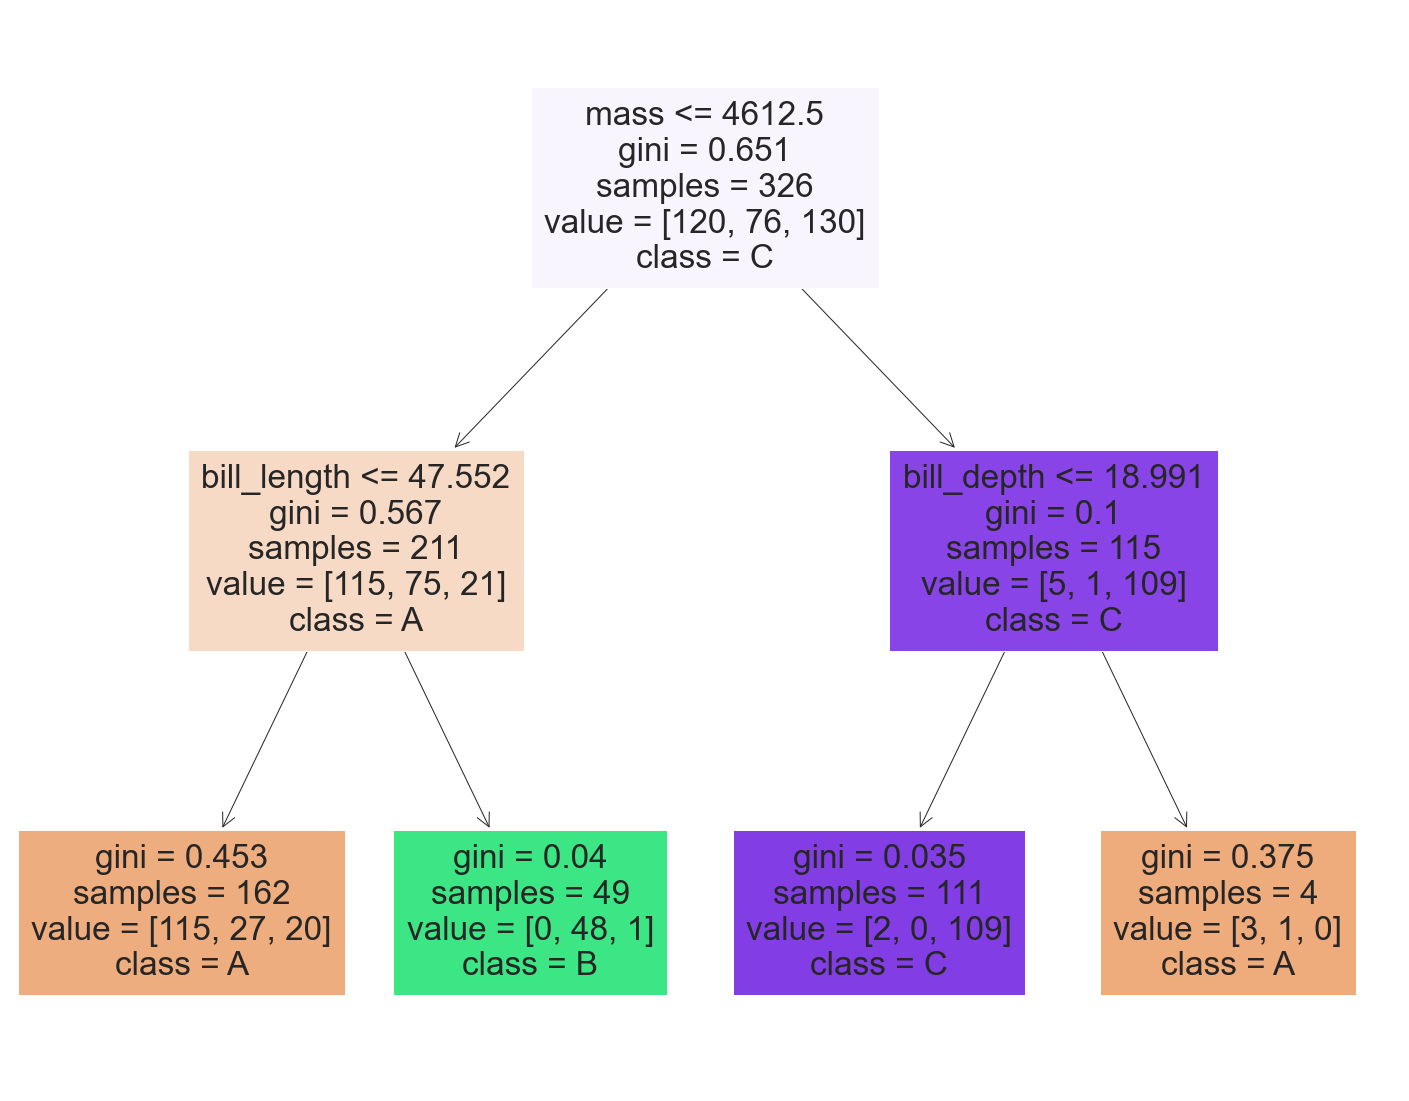

In [53]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree_model, 
                   feature_names=X.columns,  
                   class_names=list(class_names),
                   filled=True)

We see how the feature importance is used in this visualization of our decision tree classifier.

In root node, if the mass is lower than around 4600, it then checks for bill_length, else it checks for bill_depth, and then at the leaf is where it predicts the classes.

## Predict on test data

Now it's time to do the same feature preprocessing and engineering we did to the train data, before we fit our model on the test data.

In [35]:
le = LabelEncoder()

cat_imp = SimpleImputer(strategy="most_frequent")
num_imp = SimpleImputer(strategy="median")

test[cat_cols] = cat_imp.fit_transform(test[cat_cols])
test[num_cols] = num_imp.fit_transform(test[num_cols])

for col in cat_cols:
    if test[col].dtype == "object":
        test[col] = le.fit_transform(test[col])

# Convert cat_features to pd.Categorical dtype
for col in cat_cols:
    test[col] = pd.Categorical(test[col])

# save ID column
test_id = test["ID"]

all_cols.remove('species')
test = test[all_cols]

test['b_depth_length_ratio'] = test['bill_depth'] / test['bill_length']
test['b_length_depth_ratio'] = test['bill_length'] / test['bill_depth']
test['w_length_mass_ratio'] = test['wing_length'] / test['mass']

In [36]:
test_preds = dtree_model.predict(test)
submission_df = pd.concat([test_id, pd.DataFrame(test_preds, columns=['species'])], axis=1)
submission_df.head()

,ID,species
0,2,2
1,5,0
2,7,0
3,8,0
4,9,0


Notice the species value are numerical, we have to convert it back to the string values. with the label encoder with fit earlier, we can do so.

In [37]:
le_name_map

{'A': 0, 'B': 1, 'C': 2}

In [38]:
inv_map = {v: k for k, v in le_name_map.items()}
inv_map

{0: 'A', 1: 'B', 2: 'C'}

In [39]:
submission_df['species'] = submission_df['species'].map(inv_map)  
submission_df.head()

,ID,species
0,2,C
1,5,A
2,7,A
3,8,A
4,9,A


In [54]:
submission_df.to_csv('solution.csv', index=False)

Lastly, we write the data frame to a csv file and submit it!